In [41]:
%matplotlib inline
from neo4j import GraphDatabase
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

sns.set(font_scale = 1.5)

In [2]:
# Connect to Neo4j
driver = GraphDatabase.driver('bolt://localhost:7687', auth=('neo4j', 'letmein'))

def read_query(query):
    with driver.session() as session:
        result = session.run(query)
        return pd.DataFrame([r.values() for r in result], columns=result.keys())

# Exploring languages

In [3]:
read_query("""
MATCH (s:Stream)
WHERE size((s)-[:HAS_LANGUAGE]->()) > 1
RETURN s.name
""")

,s.name
0,gige


Just a single streamer with two languages, so we can just ignore multi-language streams

In [4]:
read_query("""
MATCH (l:Language)
RETURN l.name as language,
       size((l)<--()) as number_of_streams
""")

,language,number_of_streams
0,en,2344
1,ja,101
2,en-gb,224
3,fr,363
4,it,175
5,ko,351
6,ru,373
7,es,442
8,de,387
9,zh-tw,144


In [5]:
# Define a threshold of at least 100 streamers
read_query("""
MATCH (l:Language)
WHERE size((l)<--()) > 100
RETURN l.name
""")

,l.name
0,en
1,ja
2,en-gb
3,fr
4,it
5,ko
6,ru
7,es
8,de
9,zh-tw


In [6]:
# Tag streamers with other languages so that they will be ignored in the analysis
read_query("""
MATCH (l:Language)
WHERE size((l)<--()) < 100
MATCH (l)<--(streamer)
SET streamer:Exclude
RETURN distinct 'success' as result
""")

,result
0,success


# Exploring chatter network for bots etc..

In [7]:
# Exclude users with a single chatter/vip/mod relationship
read_query("""CALL apoc.periodic.iterate("
    MATCH (u:User)
    WHERE size((u)-->(:Stream)) = 1
    RETURN u",
    "SET u:Exclude",
    {batchSize:50000, parallel:true}
)""")

,batches,total,timeTaken,committedOperations,failedOperations,failedBatches,retries,errorMessages,batch,operations,wasTerminated,failedParams,updateStatistics
0,125,6234567,41,6234567,0,0,0,{},"{'total': 125, 'committed': 125, 'failed': 0, ...","{'total': 6234567, 'committed': 6234567, 'fail...",False,{},"{'nodesDeleted': 0, 'labelsAdded': 6234504, 'r..."


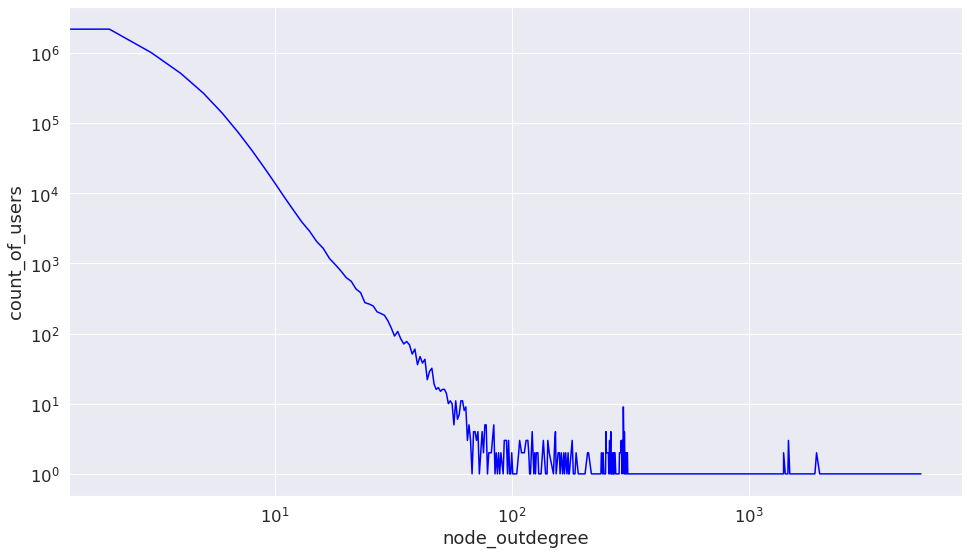

In [8]:
data = read_query("""
MATCH (u:User)
WHERE NOT u:Exclude
WITH u, size((u)-[:CHATTER|VIP|MODERATOR]->()) as node_outdegree
RETURN node_outdegree, count(*) as count_of_users
ORDER BY node_outdegree ASC""")

fig, ax = pyplot.subplots(figsize=(16,9))
ax = sns.lineplot(x="node_outdegree", y="count_of_users", data=data, color="blue")
ax.set_yscale("log")
ax.set_xscale("log")


In [9]:
read_query("""
MATCH (u:User)
WHERE NOT u:Exclude
WITH u, size((u)-[:CHATTER|VIP|MODERATOR]->()) as node_outdegree
WHERE node_outdegree > 200
RETURN u.name as user, node_outdegree
ORDER BY node_outdegree DESC
""")

,user,node_outdegree
0,commanderroot,5348
1,tawmtawmz,5200
2,virgoproz,5168
3,aten,5152
4,v_and_k,5138
...,...,...
208,oforcefield,210
209,yurivipw,210
210,killua_0715,209
211,h4x0rgin,209


In [10]:
# I decided to exclude users who have chatted in more than 200 channels... even that seems a lot
read_query("""
MATCH (u:User)
WHERE NOT u:Exclude
WITH u, size((u)-[:CHATTER|VIP|MODERATOR]->()) as node_outdegree
WHERE node_outdegree > 200
SET u:Exclude
""")

""


In [11]:
# Just check moderators for some additional bots
read_query("""
MATCH (u:User)
WHERE NOT u:Exclude
RETURN u.name as user, size((u)-[:MODERATOR]->()) as mod_count
ORDER BY mod_count DESC LIMIT 50
""")

,user,mod_count
0,fossabot,182
1,9kmmrbot,53
2,priestbot,49
3,restreambot,34
4,bbangddeock,29
5,creatisbot,28
6,logiceftbot,27
7,wzbot,26
8,mikuia,25
9,rewardtts,21


In [12]:
# Exclude users who moderate more than 10 channels
read_query("""
MATCH (u:User)
WHERE NOT u:Exclude
WITH u, size((u)-[:MODERATOR]->()) as mod_count
WHERE mod_count > 10
SET u:Exclude
RETURN distinct 'success' as result
""")

,result
0,success


# Infer co-chatter network

There are lots of possibilities here. we could use node similarity or even overlap similarity, in all honesty I think overlap makes more sense

In [13]:
read_query("""
CALL gds.graph.create.cypher("twitch",
"MATCH (u:User) WHERE NOT u:Exclude RETURN id(u) as id, labels(u) as labels",
"MATCH (s:User)-->(t:Stream)
 WHERE NOT s:Exclude AND NOT t:Exclude
 RETURN id(t) as source, id(s) as target",
{validateRelationships:false})
""")

,nodeQuery,relationshipQuery,graphName,nodeCount,relationshipCount,createMillis
0,MATCH (u:User) WHERE NOT u:Exclude RETURN id(u...,MATCH (s:User)-->(t:Stream)\n WHERE NOT s:Excl...,twitch,4279161,10389468,13572


Node similarity

In [14]:
read_query("""
CALL gds.nodeSimilarity.stats("twitch", {topK:25})
""")['similarityDistribution'].to_list()

[{'p1': 0.00029112209449522197,
  'max': 1.0000076293654274,
  'p5': 0.0015384629077743739,
  'p90': 0.03423428532551043,
  'p50': 0.00719425079296343,
  'p95': 0.05405426022480242,
  'p10': 0.002259522647364065,
  'p75': 0.016006112069590017,
  'p99': 0.12603950497577898,
  'p25': 0.00373600420425646,
  'p100': 1.0000076293654274,
  'min': 4.851986886933446e-06,
  'mean': 0.015359212897658013,
  'stdDev': 0.028131670145054653}]

In [15]:
read_query("""
CALL gds.nodeSimilarity.mutate("twitch", {topK:25, mutateProperty:'score', mutateRelationshipType:'SHARED_AUDIENCE'})
""")['similarityDistribution'].to_list()

[{'p1': 0.00029112209449522197,
  'max': 1.0000076293654274,
  'p5': 0.0015384629077743739,
  'p90': 0.03423428532551043,
  'p50': 0.00719425079296343,
  'p95': 0.05405426022480242,
  'p10': 0.002259522647364065,
  'p75': 0.016006112069590017,
  'p99': 0.12603950497577898,
  'p25': 0.00373600420425646,
  'p100': 1.0000076293654274,
  'min': 4.851986886933446e-06,
  'mean': 0.015359212897658013,
  'stdDev': 0.028131670145054653}]

In [16]:
# Just to be sure it works as intended -> Skip this otherwise
read_query("""
CALL gds.graph.export('twitch', { dbName: 'twitch' })
""")


,dbName,graphName,nodeCount,relationshipCount,relationshipTypeCount,nodePropertyCount,relationshipPropertyCount,writeMillis
0,twitch,twitch,4279161,10493256,2,0,1089074053728,18165


In [17]:
# Maybe run pageRank, who knows?
read_query("""
CALL gds.pageRank.mutate('twitch', 
{nodeLabels:['Stream'], relationshipTypes:['SHARED_AUDIENCE'], mutateProperty:'pagerank'})
""")

,mutateMillis,nodePropertiesWritten,ranIterations,didConverge,centralityDistribution,postProcessingMillis,createMillis,computeMillis,configuration
0,1,4234,20,False,"{'p99': 3.6834707260131836, 'min': 0.149999618...",24,8,264,"{'maxIterations': 20, 'relationshipWeightPrope..."


In [18]:
# fastRP

In [21]:
embeddings = read_query("""
CALL gds.beta.fastRPExtended.stream(
  "twitch",
  {nodeLabels:['Stream'], relationshipTypes:['SHARED_AUDIENCE'],
   relationshipWeightProperty:'score', embeddingDimension: 256, featureProperties: ['pagerank']}
) YIELD nodeId, embedding
MATCH (n)-[:HAS_LANGUAGE]->(l)
WHERE id(n)=nodeId
RETURN nodeId, embedding, l.name as language
""")

In [20]:
from sklearn.manifold import TSNE

In [23]:
tsne = TSNE(n_components=2, n_iter=300)
tsne_results = tsne.fit_transform(embeddings['embedding'].to_list())

In [37]:
embeddings['tsne_x'] = [x[0] for x in list(tsne_results)]
embeddings['tsne_y'] = [x[1] for x in list(tsne_results)]

<AxesSubplot:xlabel='tsne_x', ylabel='tsne_y'>

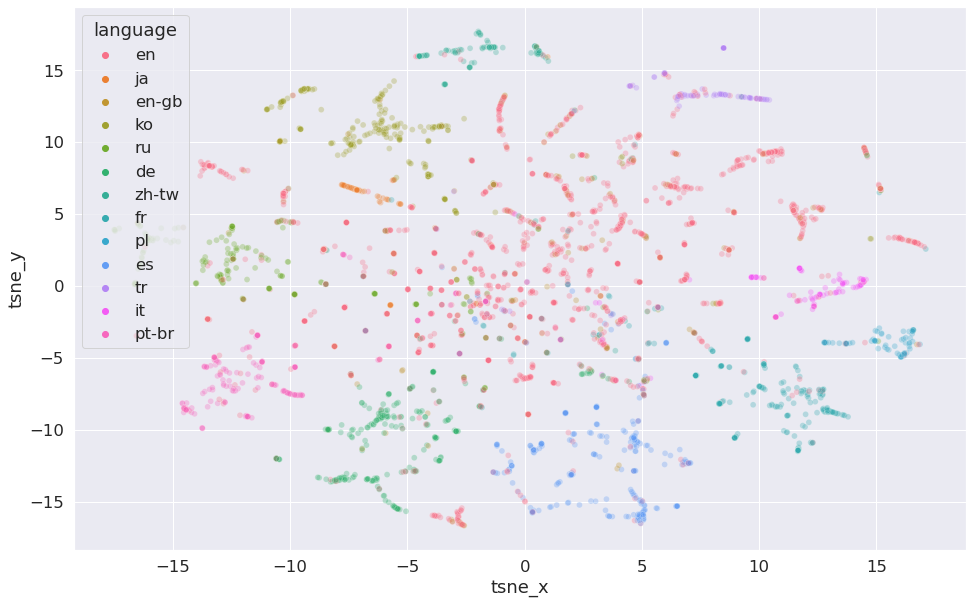

In [43]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne_x", y="tsne_y",
    hue="language",
    #palette=sns.color_palette("hls", 10),
    data=embeddings,
    legend="full",
    alpha=0.3
)